# **Single-GPU Particle Mesh Simulation with JAXPM**

In this notebook, we'll run a simple Particle Mesh (PM) simulation on a single GPU using `JAXPM`. This example provides a hands-on introduction to simulating the evolution of matter in the universe through basic PM techniques, allowing you to explore how cosmological structures form over time.

<a href="https://colab.research.google.com/github/DifferentiableUniverseInitiative/JaxPM/blob/main/notebooks/01-Introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [ ]:
!pip install --quiet git+https://github.com/DifferentiableUniverseInitiative/JaxPM.git

In [1]:
import os
import jax
import jax.numpy as jnp
import jax_cosmo as jc

from jax.experimental.ode import odeint

from jaxpm.painting import cic_paint , cic_paint_dx
from jaxpm.pm import linear_field, lpt, make_ode_fn
from jaxpm.distributed import uniform_particles

### **Particle Mesh Simulation Setup**

In this example, we initialize particles with uniform positions across the grid. This setup implicitly means that the Cloud-in-Cell (CIC) painting scheme will map absolute particle positions onto the grid.


In [2]:
mesh_shape = [256, 256, 256]
box_size = [256., 256., 256.]
snapshots = jnp.array([0.1, 0.5, 1.0])

def run_simulation(omega_c, sigma8):
    # Create a small function to generate the matter power spectrum
    k = jnp.logspace(-4, 1, 128)
    pk = jc.power.linear_matter_power(jc.Planck15(Omega_c=omega_c, sigma8=sigma8), k)
    pk_fn = lambda x: jnp.interp(x.reshape([-1]), k, pk).reshape(x.shape)

    # Create initial conditions
    initial_conditions = linear_field(mesh_shape, box_size, pk_fn, seed=jax.random.PRNGKey(0))

    particles = uniform_particles(mesh_shape)
    # Create particles
    cosmo = jc.Planck15(Omega_c=omega_c, sigma8=sigma8)
    
    # Initial displacement
    dx, p, f = lpt(cosmo, initial_conditions, particles, a=0.1)
    
    # Evolve the simulation forward
    res = odeint(make_ode_fn(mesh_shape,particles), [particles + dx, p], snapshots, cosmo, rtol=1e-5, atol=1e-5)
    
    # Return the simulation volume at requested 

    return initial_conditions ,  particles + dx , res[0]

In [3]:
initial_conditions , lpt_particles , ode_particles = run_simulation(0.25, 0.8)
ode_particles[-1].block_until_ready()
%timeit initial_conditions , lpt_particles , ode_particles =  run_simulation(0.25, 0.8);ode_particles[-1].block_until_ready()

3.85 s ± 14.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


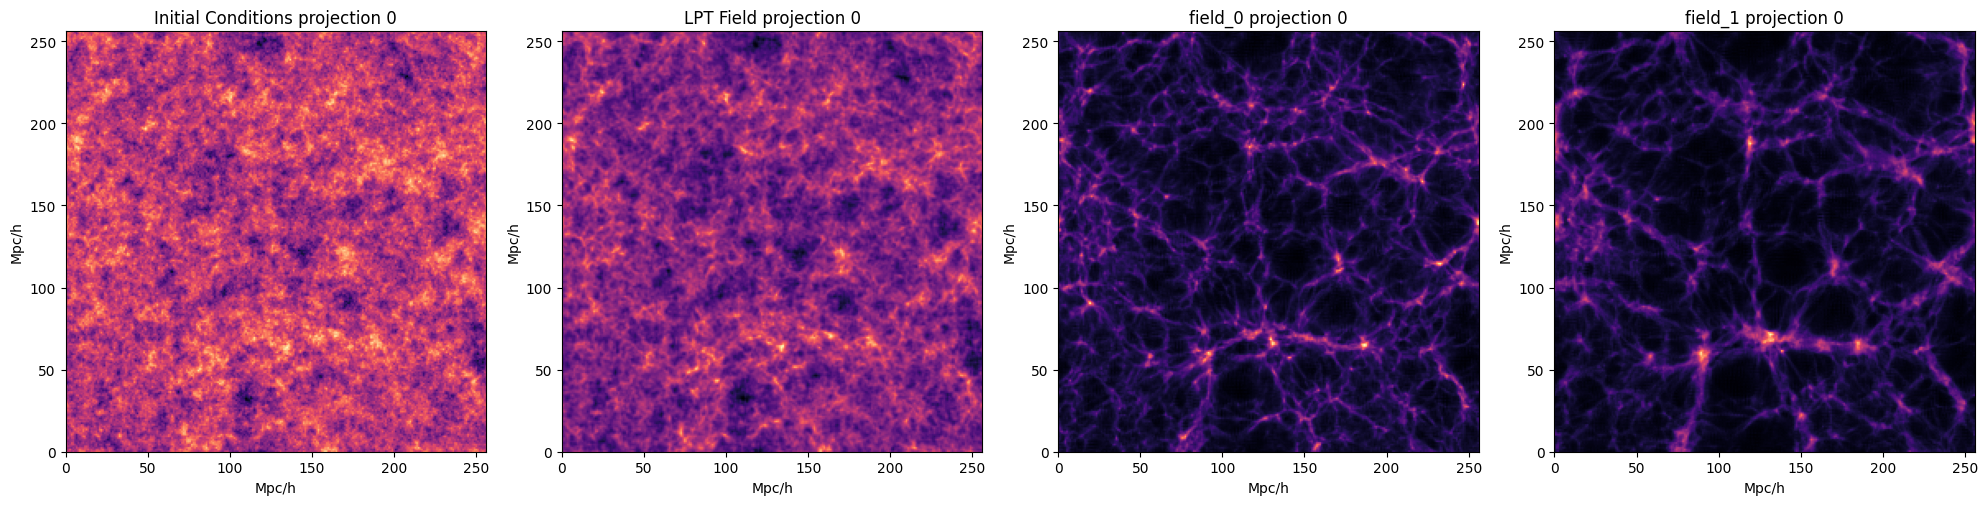

In [4]:
from visualize import plot_fields_single_projection

fields = {"Initial Conditions" : initial_conditions , "LPT Field" : cic_paint(jnp.zeros(mesh_shape) ,lpt_particles)}
for i , field in enumerate(ode_particles[1:]):
    fields[f"field_{i}"] = cic_paint(jnp.zeros(mesh_shape) , field)
plot_fields_single_projection(fields)

# **Particle Mesh Simulation Setup - Relative Position Painting**

In the second example, we leave the initial particle positions as `None`, which applies a relative position (displacement-only) CIC painting scheme. This approach assumes uniform particle positions by default, saving memory and improving efficiency, though with the trade-off of assuming uniformity.


In [5]:
mesh_shape = [256, 256, 256]
box_size = [256., 256., 256.]
snapshots = jnp.array([0.1, 0.5, 1.0])

@jax.jit
def run_simulation(omega_c, sigma8):
    # Create a small function to generate the matter power spectrum
    k = jnp.logspace(-4, 1, 128)
    pk = jc.power.linear_matter_power(jc.Planck15(Omega_c=omega_c, sigma8=sigma8), k)
    pk_fn = lambda x: jnp.interp(x.reshape([-1]), k, pk).reshape(x.shape)

    # Create initial conditions
    initial_conditions = linear_field(mesh_shape, box_size, pk_fn, seed=jax.random.PRNGKey(0))

    # Create particles
    cosmo = jc.Planck15(Omega_c=omega_c, sigma8=sigma8)
    
    # Initial displacement
    dx, p, f = lpt(cosmo, initial_conditions, a=0.1)
    
    # Evolve the simulation forward
    res = odeint(make_ode_fn(mesh_shape), [dx, p], snapshots, cosmo, rtol=1e-5, atol=1e-5)
    
    # Return the simulation volume at requested 

    return initial_conditions ,  dx , res[0]
    
initial_conditions , lpt_displacements , ode_displacements = run_simulation(0.25, 0.8)
ode_displacements[-1].block_until_ready()
%timeit initial_conditions , lpt_displacements , ode_displacements =  run_simulation(0.25, 0.8);ode_displacements[-1].block_until_ready()

5.78 s ± 1.48 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


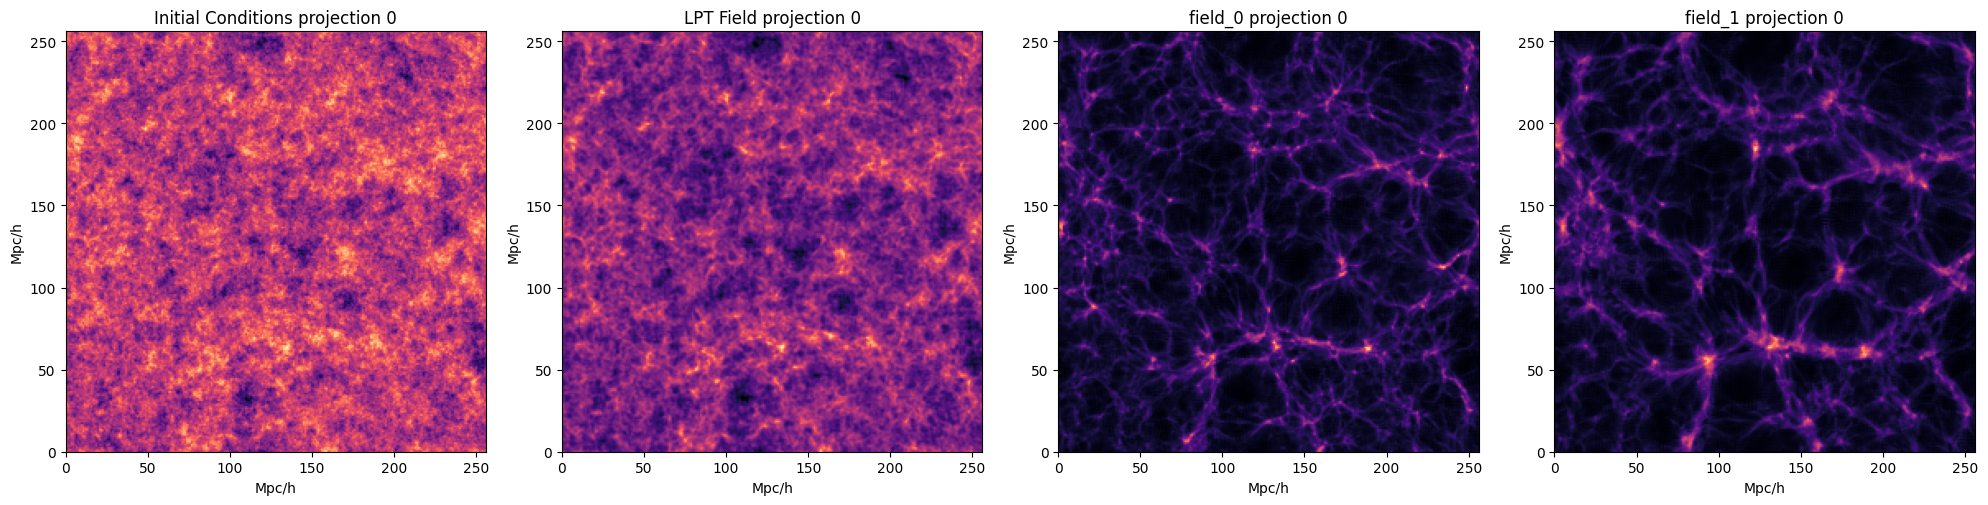

In [6]:
from visualize import plot_fields_single_projection
fields = {"Initial Conditions" : initial_conditions , "LPT Field" : cic_paint_dx(lpt_displacements)}
for i , field in enumerate(ode_displacements[1:]):
    fields[f"field_{i}"] = cic_paint_dx(field)
plot_fields_single_projection(fields)

We note that **painting only displacements is slower** than painting absolute particle positions.

This slower performance occurs because **painting displacements requires processing in smaller chunks or batches**. Instead of creating a large array of particle positions with neighbors (e.g., `(NParticles, 3, 8)`), which consumes a significant amount of memory, we paint the particles in manageable batches.

This trade-off allows for greater memory efficiency but comes at the expense of speed. By reducing the memory footprint, we avoid memory limitations, especially useful in large-scale or distributed PM simulations, even if it means slightly slower painting.

We’ll see in later notebooks that retaining only the displacement is essential for distributed Particle Mesh (PM) simulations, where memory efficiency and computational speed are key.
